In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F

plt.rcParams.update({'font.size': 15})

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data import

In [3]:
daily_birth_df = pd.read_csv('data/daily-total-female-births.csv')

In [4]:
daily_birth_df.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [5]:
daily_birth_df.shape

(365, 2)

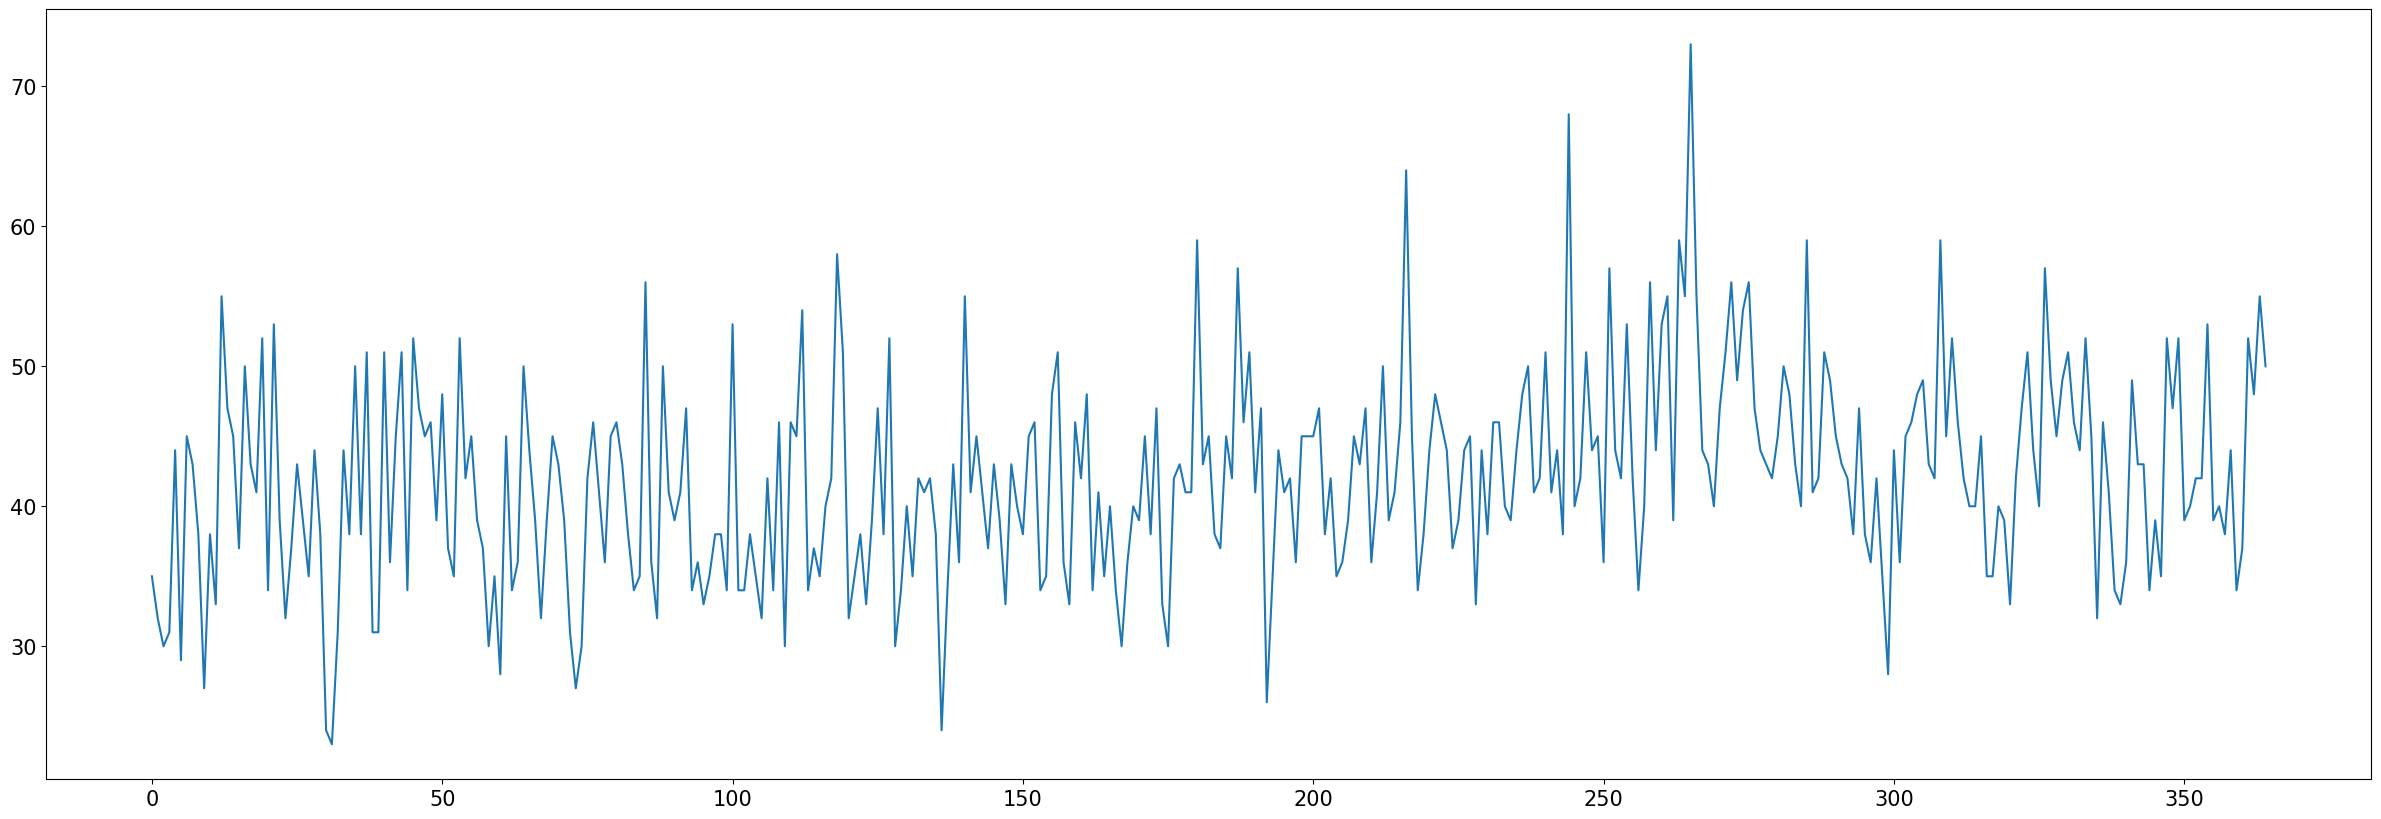

In [6]:
plt.rcParams['figure.figsize']=[30,10]

plt.plot(daily_birth_df['Births'])

In [7]:
daily_birth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


### Autoencoder

Split data into test, train and validation sets.

In [8]:
training_data = daily_birth_df['Births'][:200]
validation_data = daily_birth_df['Births'][200:]

#test_data_X_axis = val_data_X_axis[:110]
#val_data_X_axis = val_data_X_axis[110:]

In [92]:
train_dataset = [torch.tensor(s).unsqueeze(0).unsqueeze(1).float() for s in training_data]
train_dataset[:5]

[tensor([[35.]]),
 tensor([[32.]]),
 tensor([[30.]]),
 tensor([[31.]]),
 tensor([[44.]])]

In [93]:
val_dataset = [torch.tensor(s).unsqueeze(0).unsqueeze(1).float() for s in validation_data]
val_dataset[:5]

[tensor([[45.]]),
 tensor([[47.]]),
 tensor([[38.]]),
 tensor([[42.]]),
 tensor([[35.]])]

In [12]:
seq_len = 1

In [11]:
n_features = 1

### Abnormal data generation

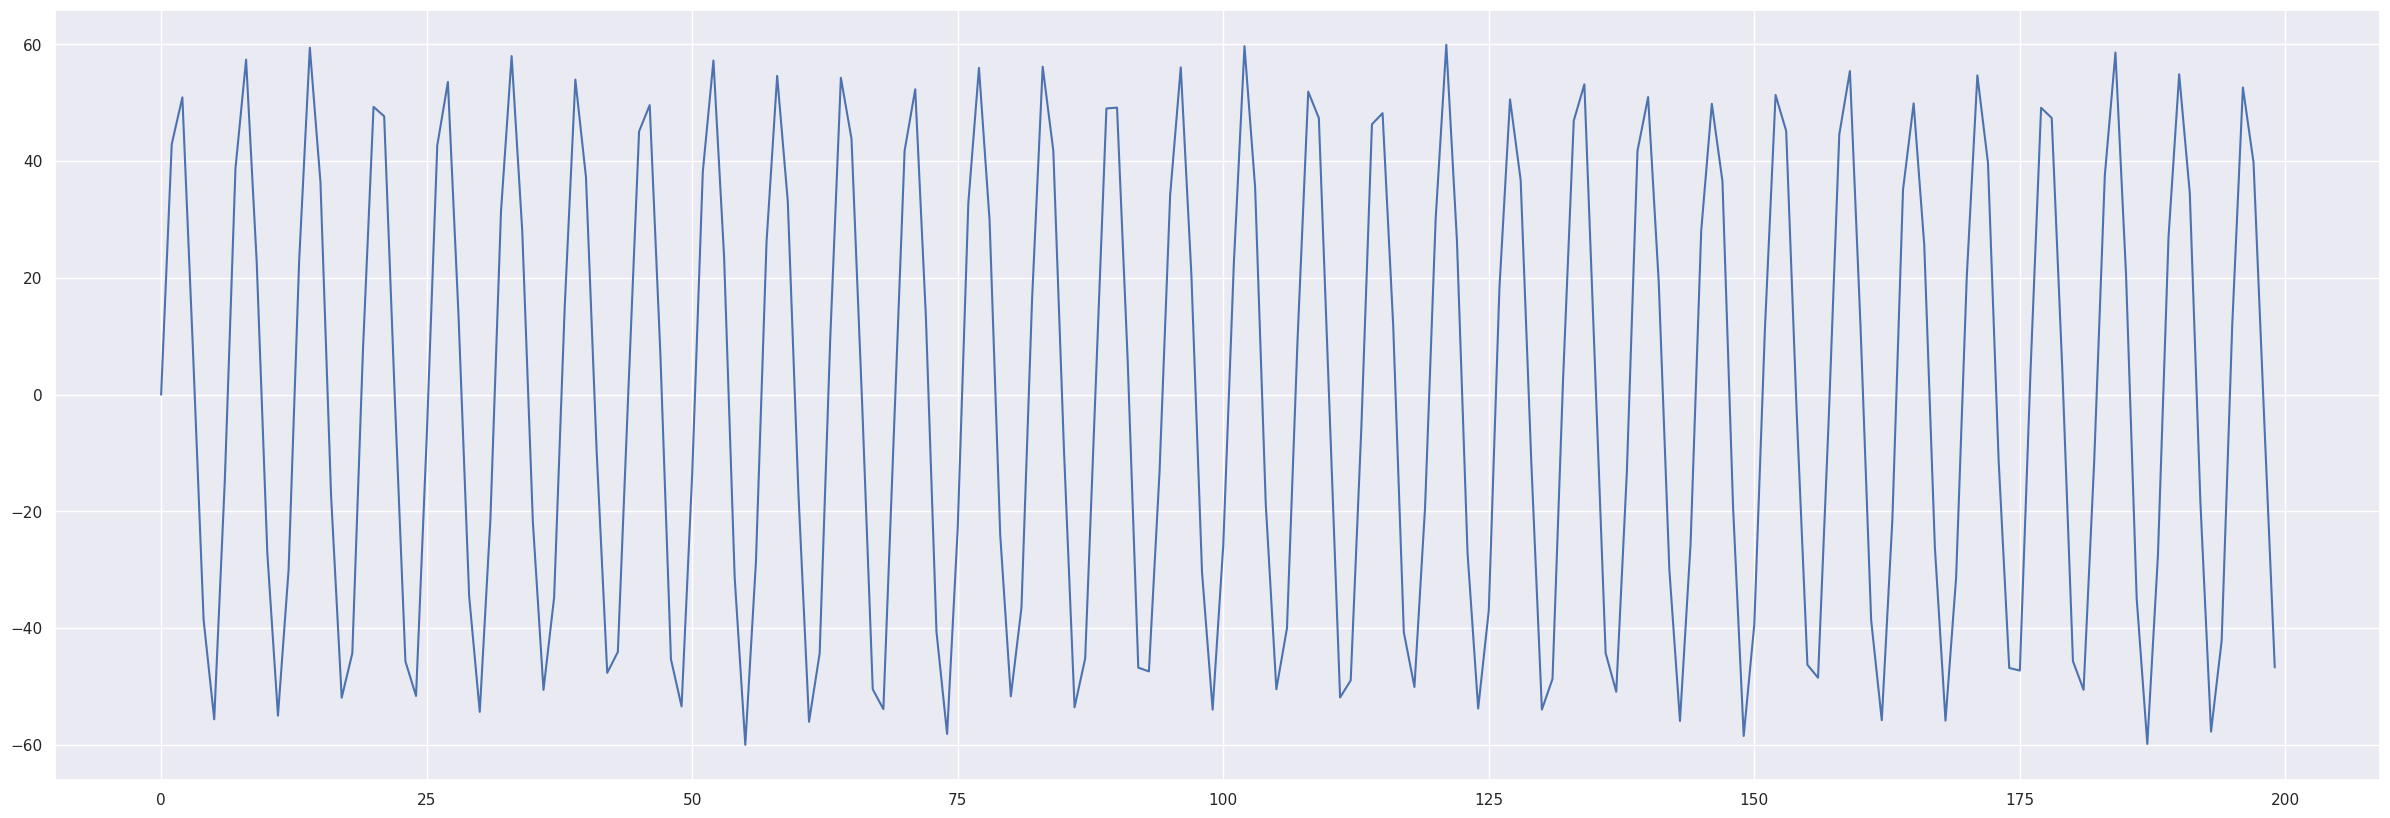

In [76]:
import random

abnormal_data = []

for k in range(200):
  abnormal_data.append(random.randint(50, 60) * np.sin(k))

plt.plot(abnormal_data)

In [94]:
abnormal_dataset = [torch.tensor(s).unsqueeze(0).unsqueeze(1).float() for s in abnormal_data]
abnormal_dataset[:5]

[tensor([[0.]]),
 tensor([[42.9150]]),
 tensor([[50.9207]]),
 tensor([[7.4794]]),
 tensor([[-38.5969]])]

### LSTM Autoencoder

In [78]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [79]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.n_features = n_features
    self.hidden_dim = input_dim

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, 1)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [34]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [35]:
model = RecurrentAutoencoder(seq_len=seq_len, n_features=n_features, embedding_dim=64)
model = model.to(device)

### Training

In [36]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):

    model = model.train()

    train_losses = []

    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())
    
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [37]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=75
)

Epoch 1: train loss 31.995520377159117 val loss 29.39726593133175
Epoch 2: train loss 19.552006349563598 val loss 18.550557026718604
Epoch 3: train loss 9.827009410858155 val loss 9.602913365219578
Epoch 4: train loss 6.0686474609375 val loss 7.182611523252545
Epoch 5: train loss 5.710308609008789 val loss 6.6096494270093515
Epoch 6: train loss 5.695482234954834 val loss 6.503811067523379
Epoch 7: train loss 5.705505352020264 val loss 6.501877224084103
Epoch 8: train loss 5.705508632659912 val loss 6.502093482739998
Epoch 9: train loss 5.705464763641357 val loss 6.5022435506184895
Epoch 10: train loss 5.70543342590332 val loss 6.5023410219134705
Epoch 11: train loss 5.705410461425782 val loss 6.5024017565178145
Epoch 12: train loss 5.705393753051758 val loss 6.502429754083807
Epoch 13: train loss 5.705381202697754 val loss 6.502431603633997
Epoch 14: train loss 5.7053725624084475 val loss 6.502413269967744
Epoch 15: train loss 5.705365333557129 val loss 6.502377689245975
Epoch 16: trai

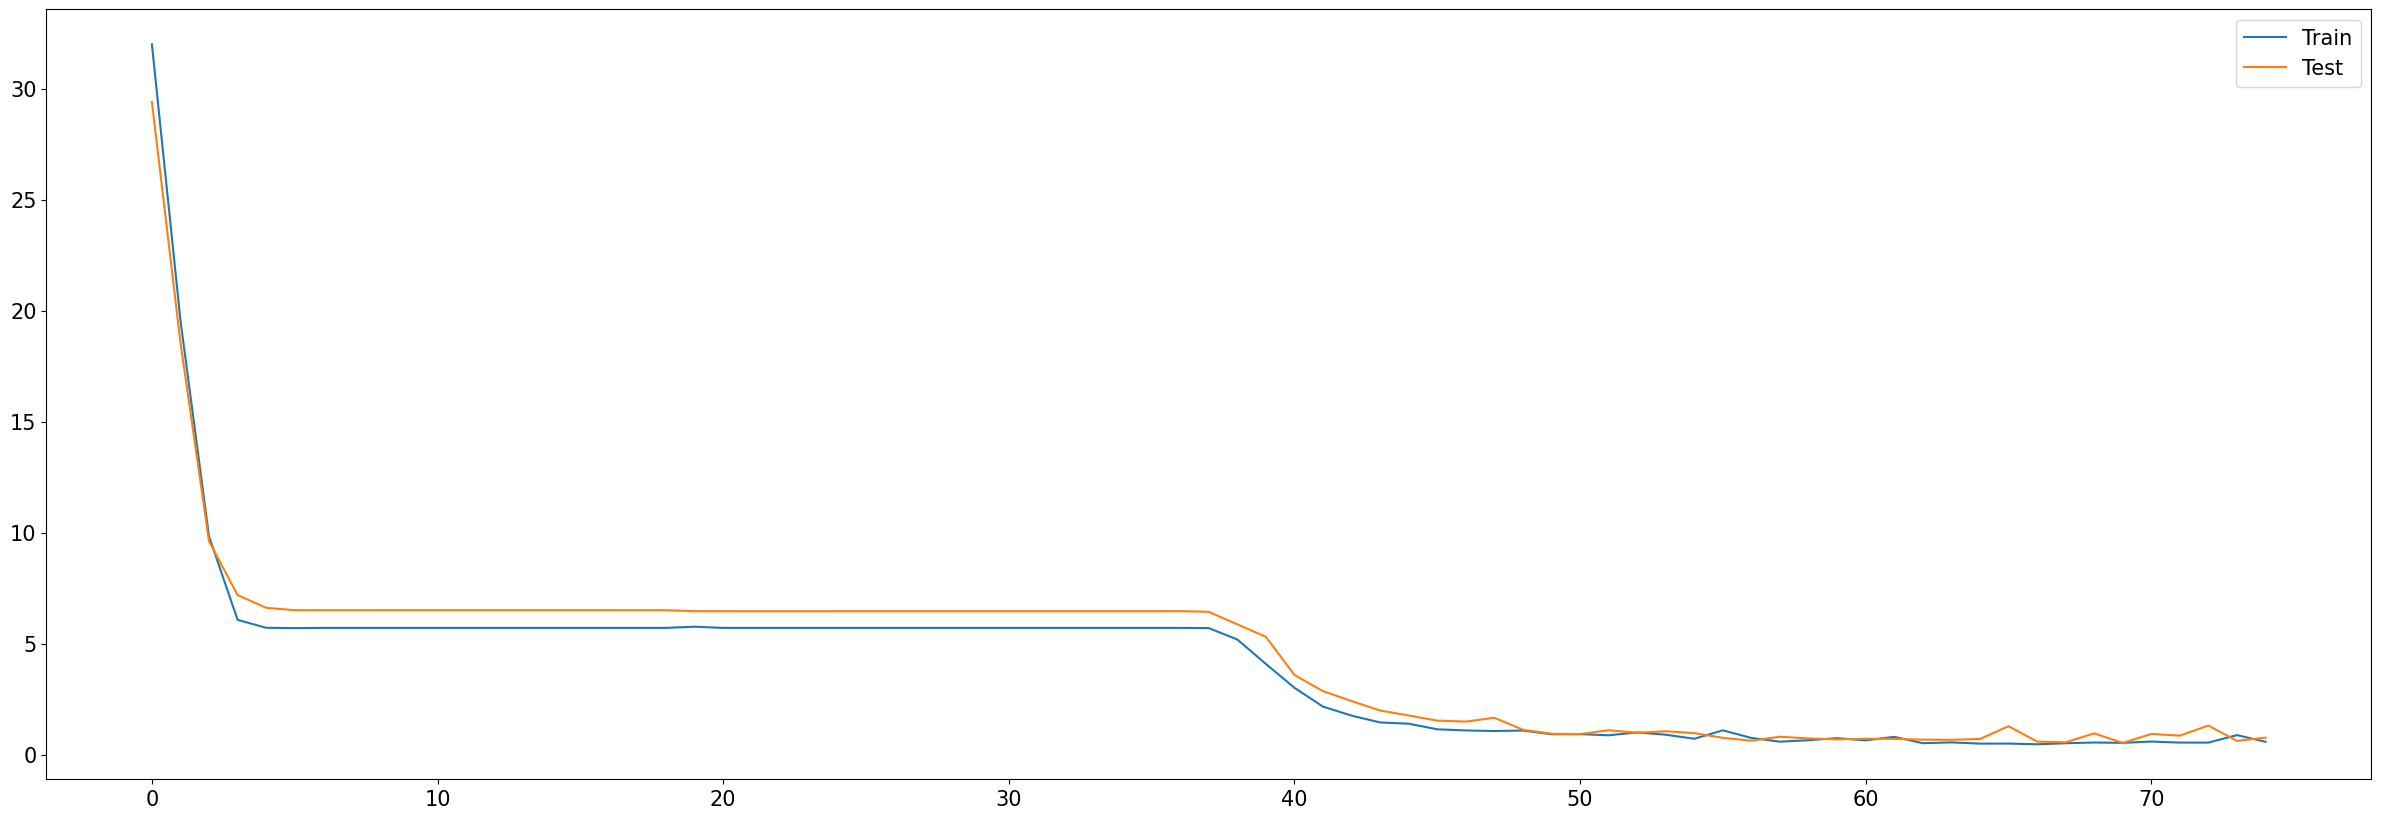

In [55]:
#ax = plt.figure.gca()

plt.plot(history['train'], label='Train')
plt.plot(history['val'], label='Test')
plt.legend()
plt.show()

### LSTM Prediction

In [38]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)

    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [39]:
train_predictions, train_losses = predict(model, train_dataset)

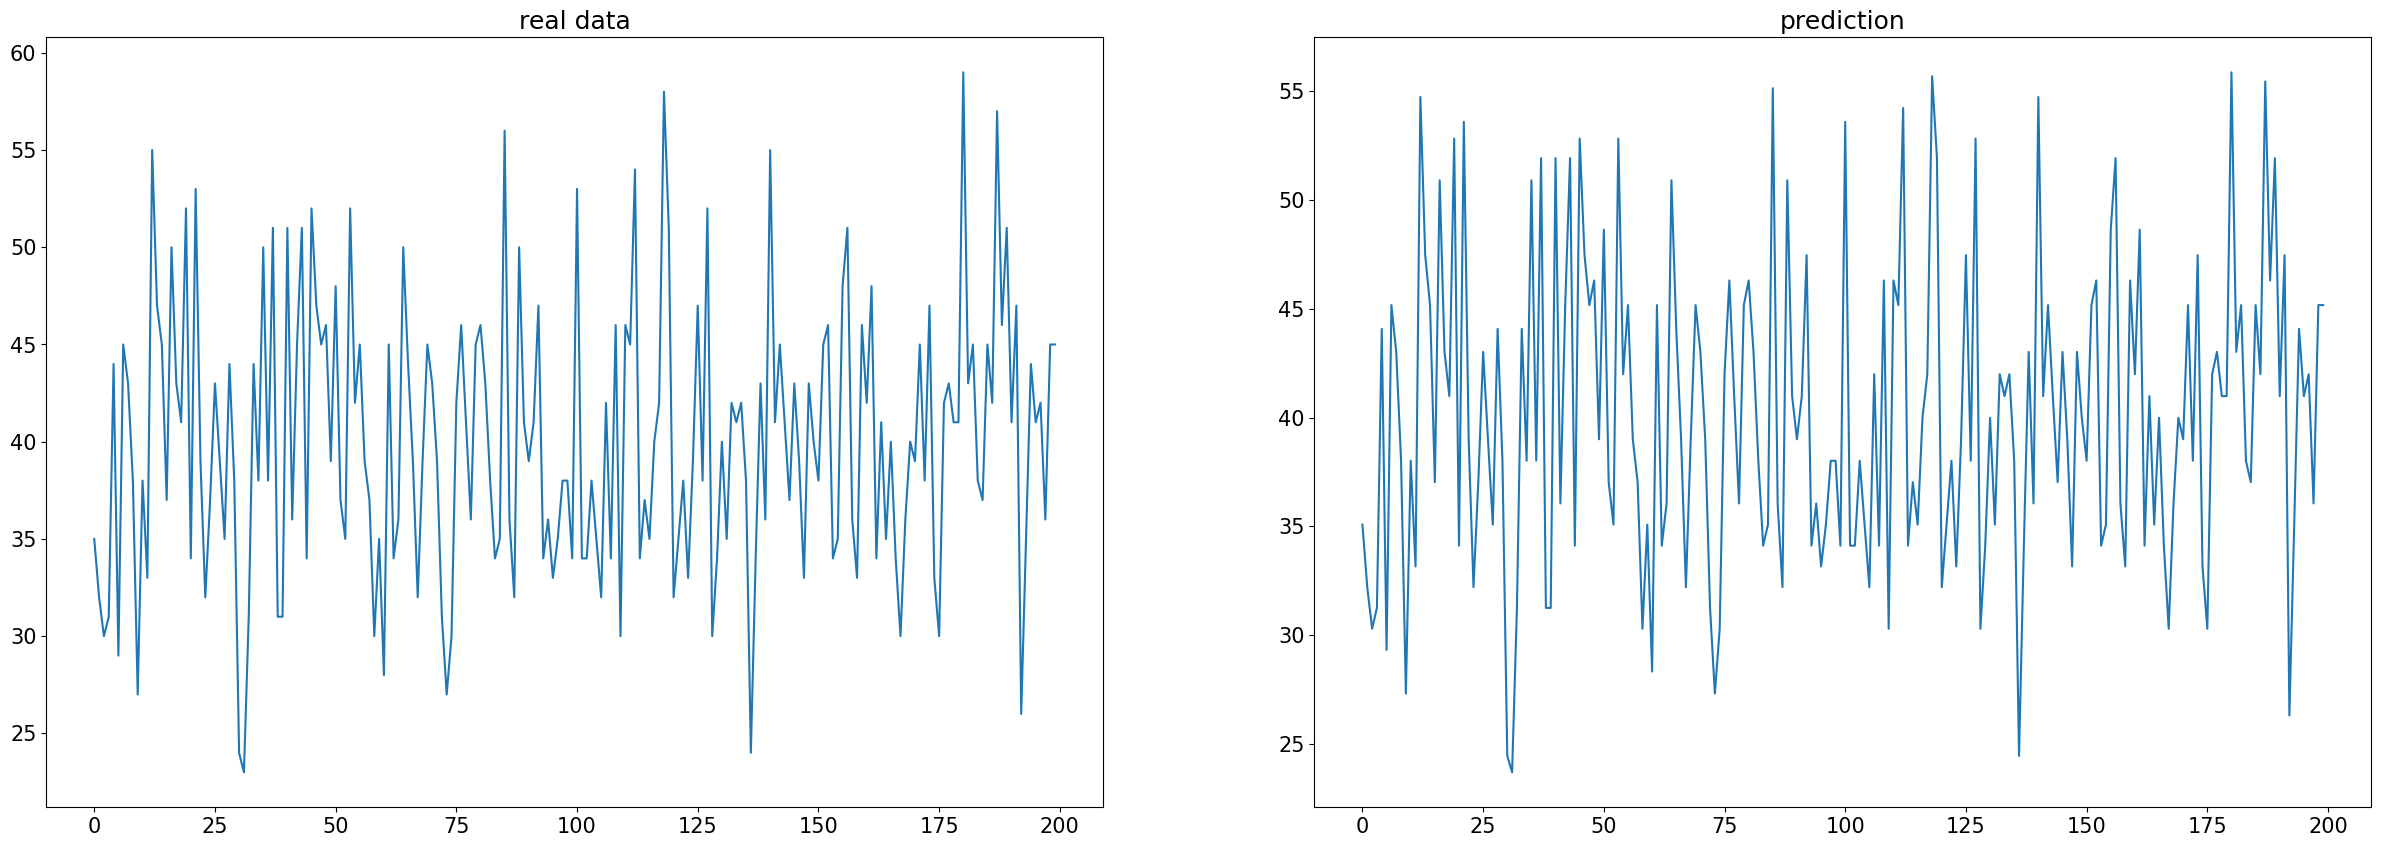

In [40]:
plt.rcParams['figure.figsize']=[30,10]

fig, ax = plt.subplots(1, 2,figsize=(11,4))
fig.set_figheight(10)
fig.set_figwidth(30)
ax[0].set_title('real data')
ax[0].plot(train_dataset)
ax[1].set_title('prediction')
ax[1].plot(train_predictions)
plt.show()

Text(0.5, 1.0, 'Train Losses Distribution')

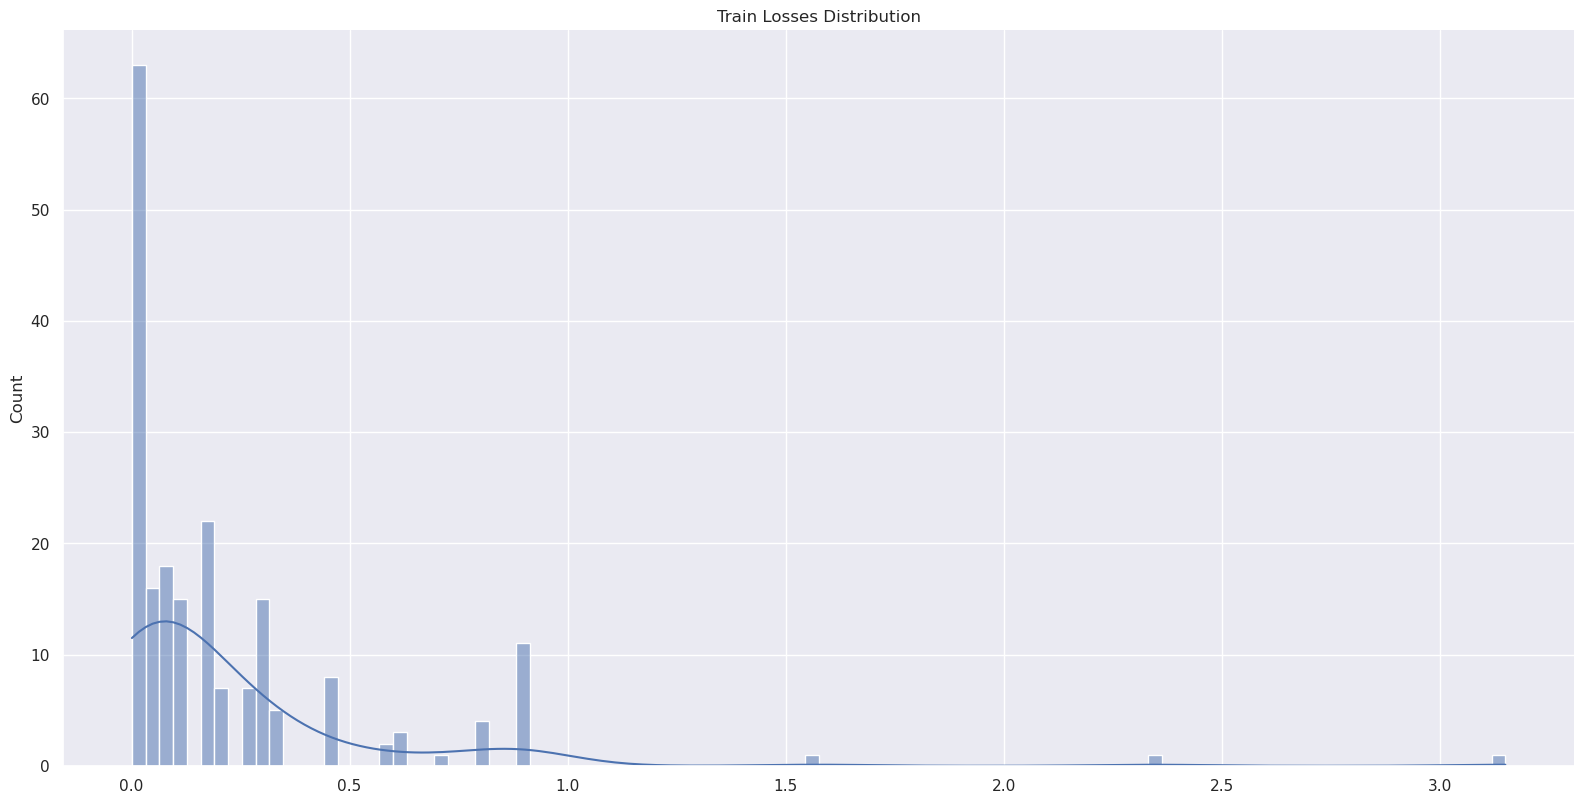

In [69]:
sns.displot(train_losses, bins=100, kde=True, height=8, aspect=2)
plt.title('Train Losses Distribution')

In [86]:
# Choosing a treshold
THRESHOLD = 0.9

In [87]:
correct = sum(l <= THRESHOLD for l in train_losses)
print('Correct normal predictions: {0}/{1}'.format(correct,len(train_losses)))

Correct normal predictions: 191/200


In [88]:
abnormal_predictions, abnormal_losses = predict(model, abnormal_dataset)

/home/zobby/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/zobby/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


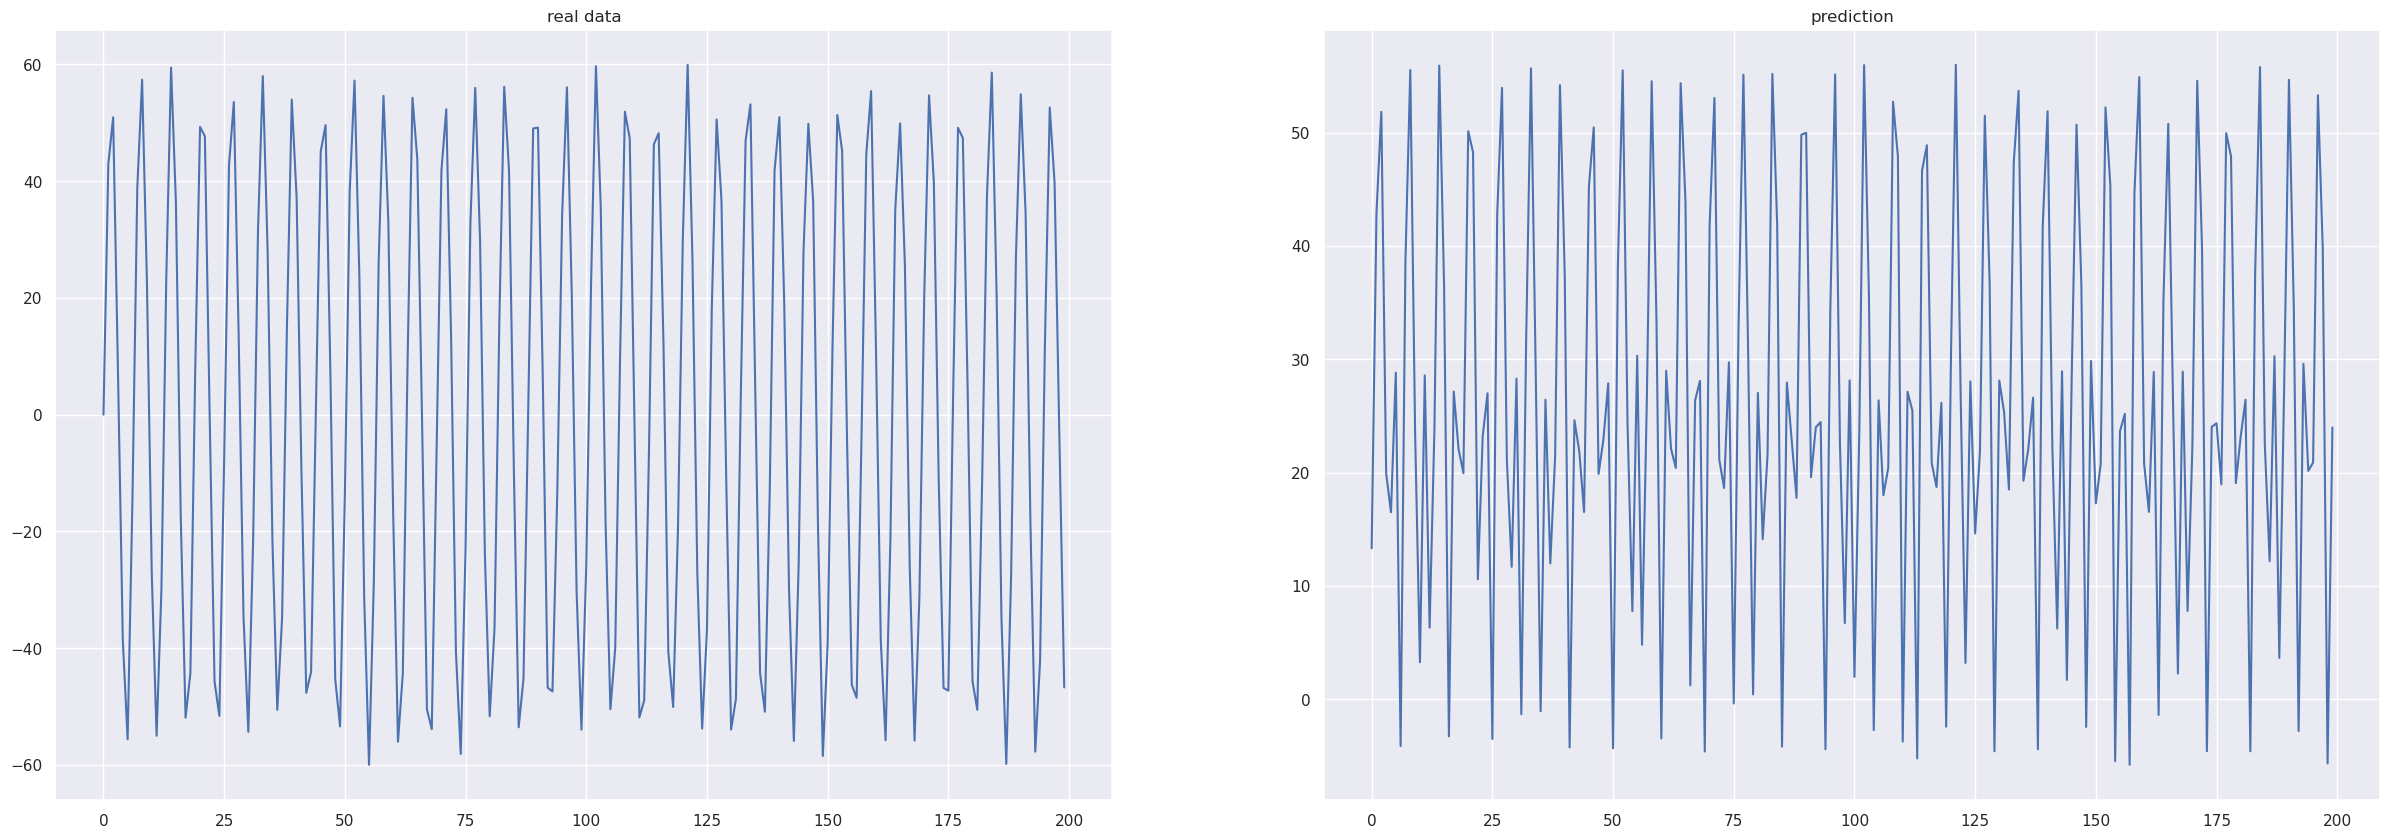

In [89]:
plt.rcParams['figure.figsize']=[30,10]

fig, ax = plt.subplots(1, 2,figsize=(11,4))
fig.set_figheight(10)
fig.set_figwidth(30)
ax[0].set_title('real data')
ax[0].plot(abnormal_dataset)
ax[1].set_title('prediction')
ax[1].plot(abnormal_predictions)
plt.show()

Text(0.5, 1.0, 'Anomaly Losses Distribution')

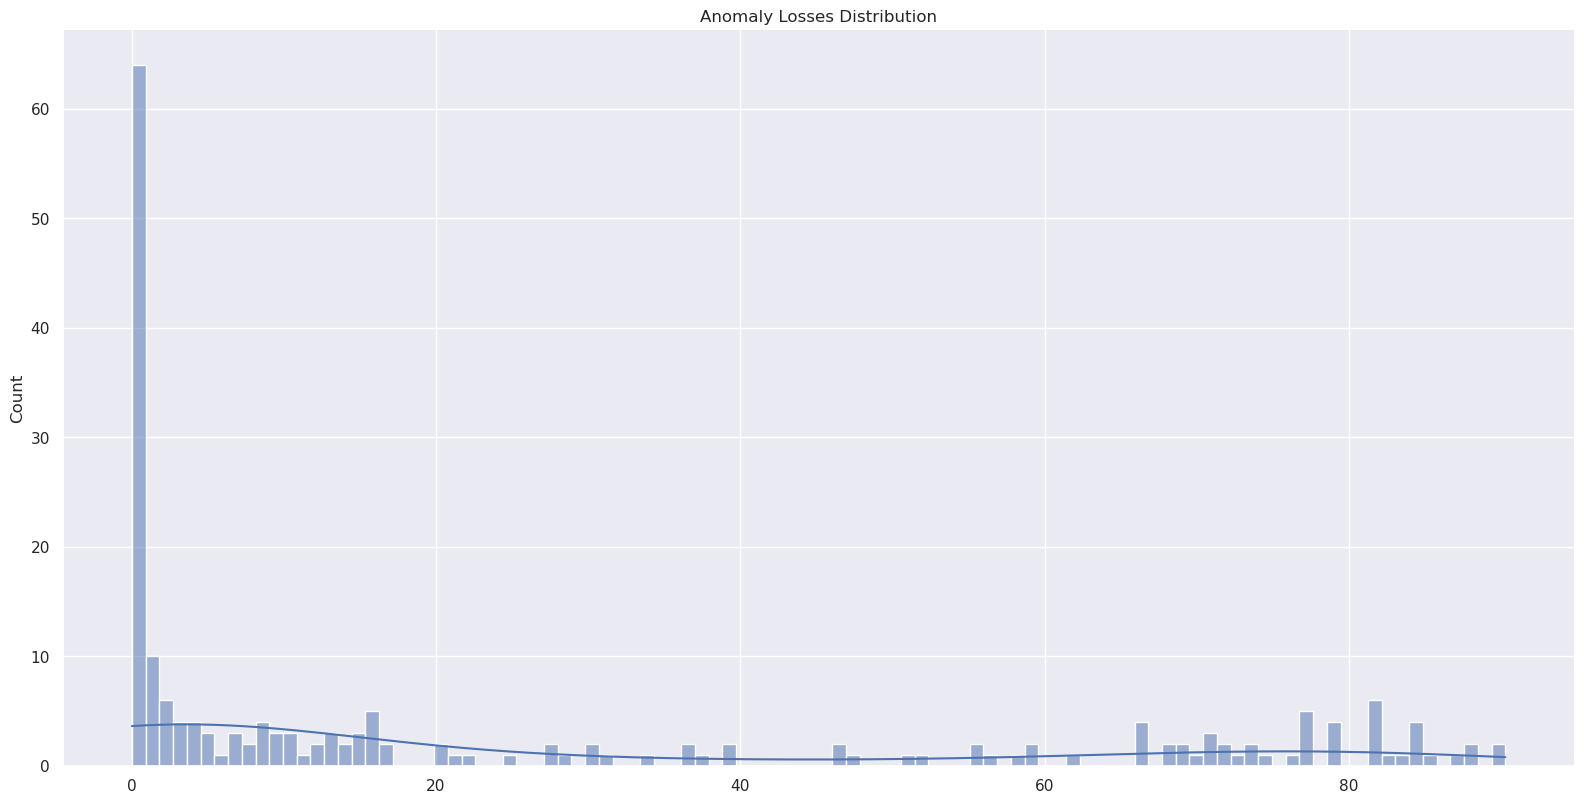

In [90]:
sns.displot(abnormal_losses, bins=100, kde=True, height=8, aspect=2)
plt.title('Anomaly Losses Distribution')

In [91]:
correct = sum(l >= THRESHOLD for l in abnormal_losses)
print('Correct anomaly predictions: {0}/{1}'.format(correct,len(train_losses)))

Correct anomaly predictions: 136/200
